# Import

In [14]:
# Import các thư viện cần thiết
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display
from pathlib import Path

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_style("whitegrid")


In [15]:
df_non_financial = pd.read_csv("../data/processed/fa/non_financial_data.csv")
df_financial = pd.read_csv("../data/processed/fa/financial_data.csv")

## Ranking FA

### 1. Chuẩn bị dữ liệu cho Ranking

In [16]:
# ✓ SỬ DỤNG LẠI df_non_financial từ phần EDA (đã có ROA, ROE, Current_Ratio, D_E_Ratio)
print("=" * 80)
print("PREPARING DATA FOR RANKING (Reusing df_non_financial)")
print("=" * 80)

# Filter recent quarters (last 4 quarters) from df_non_financial
df_non_financial['year_quarter'] = df_non_financial['Năm'].astype(str) + '_Q' + df_non_financial['Kỳ'].astype(str)

# Get latest data
latest_periods = sorted(df_non_financial['year_quarter'].unique(), reverse=True)[:11]
df_recent = df_non_financial[df_non_financial['year_quarter'].isin(latest_periods)].copy()

print(f"\n✓ Filtered to {len(latest_periods)} recent quarters: {latest_periods}")
print(f"✓ Dataset size: {df_recent.shape[0]:,} rows")
print(f"✓ Unique stocks: {df_recent['CP'].nunique()}")

# Preview available metrics from EDA
print("\n✓ Available metrics from EDA:")
metric_cols = ['CP', 'Năm', 'Kỳ', 'Doanh thu (đồng)', 'Lợi nhuận sau thuế của Cổ đông công ty mẹ (đồng)', 
               'ROA', 'ROE', 'Current_Ratio', 'D_E_Ratio']
print(f"  {[c for c in metric_cols if c in df_recent.columns]}")

display(df_recent[metric_cols].head(10))


PREPARING DATA FOR RANKING (Reusing df_non_financial)

✓ Filtered to 11 recent quarters: ['2025_Q3', '2025_Q2', '2025_Q1', '2024_Q4', '2024_Q3', '2024_Q2', '2024_Q1', '2023_Q4', '2023_Q3', '2023_Q2', '2023_Q1']
✓ Dataset size: 12,112 rows
✓ Unique stocks: 1147

✓ Available metrics from EDA:
  ['CP', 'Năm', 'Kỳ', 'Doanh thu (đồng)', 'Lợi nhuận sau thuế của Cổ đông công ty mẹ (đồng)', 'ROA', 'ROE', 'Current_Ratio', 'D_E_Ratio']


,CP,Năm,Kỳ,Doanh thu (đồng),Lợi nhuận sau thuế của Cổ đông công ty mẹ (đồng),ROA,ROE,Current_Ratio,D_E_Ratio
0,AAA,2025,3,2371755171900.0000,117554438469.0000,0.0102,0.0208,1.4071,1.0342
1,AAA,2025,2,2310908388011.0000,131689030063.0000,0.0149,0.0310,1.4271,1.0804
2,AAA,2025,1,3857615161473.0000,45239813399.0000,0.0046,0.0092,1.5682,1.0183
3,AAA,2024,4,3844069138022.0000,76186464918.0000,0.0046,0.0102,1.5550,1.2078
4,AAA,2024,3,3194720984754.0000,21799597923.0000,-0.0020,-0.0042,1.6818,1.1447
5,AAA,2024,2,2784044828229.0000,135887872408.0000,0.0112,0.0224,1.7053,0.9908
6,AAA,2024,1,2964878299224.0000,134706559842.0000,0.0123,0.0237,1.6137,0.9273
7,AAA,2023,4,2687154224910.0000,93772934728.0000,0.0080,0.0156,1.5182,0.9484
8,AAA,2023,3,3531352090707.0000,99049764272.0000,0.0089,0.0161,1.8272,0.8007
9,AAA,2023,2,2792257990090.0000,42275112576.0000,0.0044,0.0079,1.6795,0.7701


### 2. Tính toán các chỉ số tài chính

In [17]:
# ✓ TẬN DỤNG các metrics ĐÃ CÓ từ df_non_financial
print("=" * 80)
print("CALCULATING FINANCIAL METRICS (Using existing ROA, ROE, Current_Ratio, D_E_Ratio)")
print("=" * 80)

# Rename columns for easier access
rename_dict = {
    'CP': 'symbol',
    'Doanh thu (đồng)': 'revenue',
    'Lợi nhuận sau thuế của Cổ đông công ty mẹ (đồng)': 'net_profit',
    'Tăng trưởng doanh thu (%)': 'revenue_growth_pct',
    'Tăng trưởng lợi nhuận (%)': 'profit_growth_pct',
    'Lãi gộp': 'gross_profit',
    'Doanh thu thuần': 'net_revenue',
    'TỔNG CỘNG TÀI SẢN (đồng)': 'total_assets',
}

# Add Cash Flow columns only if they exist
if 'Dòng tiền thuần từ hoạt động kinh doanh' in df_recent.columns:
    rename_dict['Dòng tiền thuần từ hoạt động kinh doanh'] = 'ocf'
if 'Tiền chi để mua sắm XDCB và tài sản dài hạn khác' in df_recent.columns:
    rename_dict['Tiền chi để mua sắm XDCB và tài sản dài hạn khác'] = 'capex'

df_recent = df_recent.rename(columns=rename_dict)

# Calculate derived metrics from Income Statement & Balance Sheet
df_recent['gross_margin'] = (df_recent['gross_profit'] / df_recent['net_revenue']) * 100
df_recent['net_margin'] = (df_recent['net_profit'] / df_recent['revenue']) * 100

# Calculate Cash Flow metrics only if columns exist
has_cash_flow = 'ocf' in df_recent.columns and 'capex' in df_recent.columns

if has_cash_flow:
    df_recent['ocf_quality'] = df_recent['ocf'] / df_recent['net_profit'].replace(0, np.nan)
    df_recent['free_cash_flow'] = df_recent['ocf'] - df_recent['capex']
    print("\n✓ Cash Flow metrics available: OCF Quality, Free Cash Flow")
else:
    # Set dummy values if Cash Flow data not available
    df_recent['ocf_quality'] = 1.0  # Neutral value
    df_recent['free_cash_flow'] = df_recent['net_profit']  # Proxy with net profit
    print("\n⚠ Cash Flow data not available - using proxy values")

df_recent['asset_turnover'] = df_recent['revenue'] / df_recent['total_assets'].replace(0, np.nan)

# Aggregate by stock - mean values
agg_dict = {
    # Profitability (from EDA + new)
    'net_profit': 'mean',
    'gross_margin': 'mean',
    'net_margin': 'mean',
    'ROA': 'mean',  # ✓ From EDA
    'ROE': 'mean',  # ✓ From EDA
    
    # Growth
    'revenue_growth_pct': 'mean',
    'profit_growth_pct': 'mean',
    
    # Scale
    'revenue': 'mean',
    
    # Financial Health (from EDA)
    'Current_Ratio': 'mean',  # ✓ From EDA
    'D_E_Ratio': 'mean',      # ✓ From EDA
    
    # Cash Quality
    'ocf_quality': 'mean',
    'free_cash_flow': 'mean',
    
    # Asset Efficiency
    'asset_turnover': 'mean',
}

stock_metrics = df_recent.groupby('symbol').agg(agg_dict).reset_index()

# Rename columns
stock_metrics.columns = ['symbol', 'avg_net_profit', 'avg_gross_margin', 'avg_net_margin', 
                          'avg_roa', 'avg_roe',
                          'avg_revenue_growth', 'avg_profit_growth', 
                          'avg_revenue',
                          'avg_current_ratio', 'avg_de_ratio',
                          'avg_ocf_quality', 'avg_fcf',
                          'avg_asset_turnover']

# Calculate stability metrics separately (std)
stability_metrics = df_recent.groupby('symbol').agg({
    'net_margin': 'std',
    'revenue_growth_pct': 'std',
    'ROA': 'std',  # ✓ Stability of ROA
}).reset_index()
stability_metrics.columns = ['symbol', 'std_net_margin', 'std_revenue_growth', 'std_roa']

# Merge
stock_metrics = stock_metrics.merge(stability_metrics, on='symbol', how='left')

# Remove stocks with missing key metrics
stock_metrics = stock_metrics.dropna()

print(f"\n✓ Calculated metrics for {len(stock_metrics)} stocks")
print(f"✓ Metrics include: ROA, ROE, Current_Ratio, D_E_Ratio (from EDA)")
if has_cash_flow:
    print(f"✓ Plus: OCF Quality, Free Cash Flow, Asset Turnover (newly calculated)")
else:
    print(f"✓ Plus: Asset Turnover (newly calculated), Cash Flow proxies used")
print("\nSample metrics:")
display(stock_metrics.head(10))


CALCULATING FINANCIAL METRICS (Using existing ROA, ROE, Current_Ratio, D_E_Ratio)

⚠ Cash Flow data not available - using proxy values

✓ Calculated metrics for 1053 stocks
✓ Metrics include: ROA, ROE, Current_Ratio, D_E_Ratio (from EDA)
✓ Plus: Asset Turnover (newly calculated), Cash Flow proxies used

Sample metrics:


,symbol,avg_net_profit,avg_gross_margin,avg_net_margin,avg_roa,avg_roe,avg_revenue_growth,avg_profit_growth,avg_revenue,avg_current_ratio,avg_de_ratio,avg_ocf_quality,avg_fcf,avg_asset_turnover,std_net_margin,std_revenue_growth,std_roa
0,AAA,86550642630.5455,11.3082,3.0195,0.0076,0.0148,-0.0552,0.7046,3086941199348.2729,1.6110,0.9702,1.0000,86550642630.5455,0.2566,1.7759,0.2435,0.0047
1,AAH,3679848035.2500,6.9224,1.4734,0.0026,0.0031,0.5333,4.4717,250787282126.6250,2.1071,0.1859,1.0000,3679848035.2500,0.1757,2.2113,1.2835,0.0034
2,AAM,-259665290.0909,4.5141,-0.9560,-0.0012,-0.0013,0.0532,-0.6841,41262627898.6364,22.3921,0.0503,1.0000,-259665290.0909,0.1963,3.3481,0.4648,0.0060
3,AAS,29281337322.0000,54.4713,18.8060,0.0083,0.0128,-0.1825,0.1858,139471106456.1818,3.1447,0.5875,1.0000,29281337322.0000,0.0431,13.2922,0.5669,0.0074
4,AAT,2146184016.8182,10.2611,0.9185,0.0017,0.0027,0.1263,8.3514,162030674391.0909,2.0756,0.6077,1.0000,2146184016.8182,0.1390,4.8773,0.7823,0.0056
5,AAV,24780765.0000,26.6791,-241.4402,-0.0000,0.0001,19.5249,-9.0992,28687926329.5455,6.0242,0.2061,1.0000,24780765.0000,0.0295,360.5223,36.8082,0.0117
6,ABC,3765480959.6364,0.4683,1.1042,0.0048,0.0067,0.1802,1.9246,303670464312.6364,2.7780,0.5296,1.0000,3765480959.6364,0.3907,1.8867,0.6249,0.0110
7,ABI,59204615122.2727,33.9175,10.0875,0.0143,0.0376,0.1037,0.4417,598209992934.3636,1.5494,1.6403,1.0000,59204615122.2727,0.1437,5.1466,0.0745,0.0071
8,ABR,5399072405.6364,57.7396,39.9553,0.0148,0.0181,-0.1748,52.1355,9778685943.7273,3.6215,0.2105,1.0000,5399072405.6364,0.0267,67.7039,0.9920,0.0102
9,ABS,-25669856150.5455,2.9279,-73.7020,-0.0375,-0.0417,-0.3780,-7.8305,141134051728.9091,5.6012,0.4548,1.0000,-25669856150.5455,0.1008,251.4327,0.4956,0.1264


### 3. Tính điểm theo từng tiêu chí

In [18]:
# Min-Max scaling function (0-100 scale)
def scale_score(series, reverse=False):
    """
    Scale series to 0-100 range.
    reverse=True: lower value = higher score (for volatility/std)
    """
    min_val = series.min()
    max_val = series.max()
    
    if max_val == min_val:
        return pd.Series([50] * len(series), index=series.index)
    
    if reverse:
        # Lower value = better score
        scaled = 100 - ((series - min_val) / (max_val - min_val)) * 100
    else:
        # Higher value = better score
        scaled = ((series - min_val) / (max_val - min_val)) * 100
    
    return scaled


print("=" * 80)
print("CALCULATING 7 COMPONENT SCORES")
print("=" * 80)

# 1. PROFITABILITY SCORE (25% weight) ← Giảm từ 40%
# Based on: ROA, ROE, gross margin, net margin
stock_metrics['roa_score'] = scale_score(stock_metrics['avg_roa'])
stock_metrics['roe_score'] = scale_score(stock_metrics['avg_roe'])
stock_metrics['gross_margin_score'] = scale_score(stock_metrics['avg_gross_margin'])
stock_metrics['net_margin_score'] = scale_score(stock_metrics['avg_net_margin'])

stock_metrics['profitability_score'] = (
    0.3 * stock_metrics['roa_score'] +
    0.3 * stock_metrics['roe_score'] +
    0.2 * stock_metrics['gross_margin_score'] +
    0.2 * stock_metrics['net_margin_score']
)

print("\n✓ 1. Profitability Score (25%): ROA, ROE, Margins")
print(f"   Range: {stock_metrics['profitability_score'].min():.2f} - {stock_metrics['profitability_score'].max():.2f}")


# 2. GROWTH SCORE (20% weight) ← Giảm từ 30%
# Based on: revenue growth, profit growth
stock_metrics['revenue_growth_score'] = scale_score(stock_metrics['avg_revenue_growth'])
stock_metrics['profit_growth_score'] = scale_score(stock_metrics['avg_profit_growth'])

stock_metrics['growth_score'] = (
    0.5 * stock_metrics['revenue_growth_score'] +
    0.5 * stock_metrics['profit_growth_score']
)

print("✓ 2. Growth Score (20%): Revenue Growth, Profit Growth")
print(f"   Range: {stock_metrics['growth_score'].min():.2f} - {stock_metrics['growth_score'].max():.2f}")


# 3. SCALE SCORE (15% weight) ← Giảm từ 20%
# Based on: revenue size, profit size
stock_metrics['revenue_size_score'] = scale_score(stock_metrics['avg_revenue'])
stock_metrics['profit_size_score'] = scale_score(stock_metrics['avg_net_profit'])

stock_metrics['scale_score'] = (
    0.6 * stock_metrics['revenue_size_score'] +
    0.4 * stock_metrics['profit_size_score']
)

print("✓ 3. Scale Score (15%): Revenue, Net Profit")
print(f"   Range: {stock_metrics['scale_score'].min():.2f} - {stock_metrics['scale_score'].max():.2f}")


# 4. STABILITY SCORE (10% weight) ← GIỮ NGUYÊN
# Based on: low volatility in margins and growth (std)
stock_metrics['margin_stability_score'] = scale_score(stock_metrics['std_net_margin'], reverse=True)
stock_metrics['growth_stability_score'] = scale_score(stock_metrics['std_revenue_growth'], reverse=True)
stock_metrics['roa_stability_score'] = scale_score(stock_metrics['std_roa'], reverse=True)

stock_metrics['stability_score'] = (
    0.4 * stock_metrics['margin_stability_score'] +
    0.3 * stock_metrics['growth_stability_score'] +
    0.3 * stock_metrics['roa_stability_score']
)

print("✓ 4. Stability Score (10%): Low volatility in margins, growth, ROA")
print(f"   Range: {stock_metrics['stability_score'].min():.2f} - {stock_metrics['stability_score'].max():.2f}")


# 5. FINANCIAL HEALTH SCORE (15% weight) ← MỚI!
# Based on: Current Ratio (liquidity), D/E Ratio (leverage - lower is better)
stock_metrics['current_ratio_score'] = scale_score(stock_metrics['avg_current_ratio'])
stock_metrics['de_ratio_score'] = scale_score(stock_metrics['avg_de_ratio'], reverse=True)  # Lower debt = better

stock_metrics['financial_health_score'] = (
    0.6 * stock_metrics['current_ratio_score'] +
    0.4 * stock_metrics['de_ratio_score']
)

print("✓ 5. Financial Health Score (15%): Current Ratio, D/E Ratio ← FROM EDA")
print(f"   Range: {stock_metrics['financial_health_score'].min():.2f} - {stock_metrics['financial_health_score'].max():.2f}")


# 6. CASH QUALITY SCORE (10% weight) ← MỚI!
# Based on: OCF/Profit ratio, Free Cash Flow
stock_metrics['ocf_quality_score'] = scale_score(stock_metrics['avg_ocf_quality'])
stock_metrics['fcf_score'] = scale_score(stock_metrics['avg_fcf'])

stock_metrics['cash_quality_score'] = (
    0.6 * stock_metrics['ocf_quality_score'] +
    0.4 * stock_metrics['fcf_score']
)

print("✓ 6. Cash Quality Score (10%): OCF/Profit, Free Cash Flow")
print(f"   Range: {stock_metrics['cash_quality_score'].min():.2f} - {stock_metrics['cash_quality_score'].max():.2f}")


# 7. ASSET EFFICIENCY SCORE (5% weight) ← MỚI!
# Based on: Asset Turnover, ROA (reuse)
stock_metrics['asset_turnover_score'] = scale_score(stock_metrics['avg_asset_turnover'])

stock_metrics['asset_efficiency_score'] = (
    0.5 * stock_metrics['asset_turnover_score'] +
    0.5 * stock_metrics['roa_score']  # Reuse ROA score
)

print("✓ 7. Asset Efficiency Score (5%): Asset Turnover, ROA")
print(f"   Range: {stock_metrics['asset_efficiency_score'].min():.2f} - {stock_metrics['asset_efficiency_score'].max():.2f}")

print("\n" + "=" * 80)
print("✓ ALL 7 COMPONENT SCORES CALCULATED")
print("=" * 80)


CALCULATING 7 COMPONENT SCORES

✓ 1. Profitability Score (25%): ROA, ROE, Margins
   Range: 29.42 - 75.45
✓ 2. Growth Score (20%): Revenue Growth, Profit Growth
   Range: 0.00 - 67.63
✓ 3. Scale Score (15%): Revenue, Net Profit
   Range: 1.47 - 66.92
✓ 4. Stability Score (10%): Low volatility in margins, growth, ROA
   Range: 27.71 - 100.00
✓ 5. Financial Health Score (15%): Current Ratio, D/E Ratio ← FROM EDA
   Range: 0.49 - 71.37
✓ 6. Cash Quality Score (10%): OCF/Profit, Free Cash Flow
   Range: 30.00 - 70.00
✓ 7. Asset Efficiency Score (5%): Asset Turnover, ROA
   Range: 6.41 - 93.98

✓ ALL 7 COMPONENT SCORES CALCULATED


### 4. Tính điểm tổng và Ranking

In [19]:
# Calculate final score with NEW 7-component weights
WEIGHT_PROFITABILITY = 0.25  # ↓ từ 40%
WEIGHT_GROWTH = 0.20         # ↓ từ 30%
WEIGHT_SCALE = 0.15          # ↓ từ 20%
WEIGHT_STABILITY = 0.10      # = giữ nguyên
WEIGHT_FINANCIAL_HEALTH = 0.15  # ← MỚI (from EDA metrics)
WEIGHT_CASH_QUALITY = 0.10      # ← MỚI (Cash Flow)
WEIGHT_ASSET_EFFICIENCY = 0.05  # ← MỚI (Asset Turnover)

print("=" * 80)
print("FINAL SCORE CALCULATION")
print("=" * 80)
print("\nWeights:")
print(f"  • Profitability:      {WEIGHT_PROFITABILITY:.0%} (ROA, ROE, Margins)")
print(f"  • Growth:             {WEIGHT_GROWTH:.0%} (Revenue/Profit Growth)")
print(f"  • Scale:              {WEIGHT_SCALE:.0%} (Company Size)")
print(f"  • Stability:          {WEIGHT_STABILITY:.0%} (Low Volatility)")
print(f"  • Financial Health:   {WEIGHT_FINANCIAL_HEALTH:.0%} ← FROM EDA (Current Ratio, D/E)")
print(f"  • Cash Quality:       {WEIGHT_CASH_QUALITY:.0%} ← NEW (OCF/Profit, FCF)")
print(f"  • Asset Efficiency:   {WEIGHT_ASSET_EFFICIENCY:.0%} ← NEW (Asset Turnover)")
print(f"  Total: {WEIGHT_PROFITABILITY + WEIGHT_GROWTH + WEIGHT_SCALE + WEIGHT_STABILITY + WEIGHT_FINANCIAL_HEALTH + WEIGHT_CASH_QUALITY + WEIGHT_ASSET_EFFICIENCY:.0%}")

stock_metrics['final_score'] = (
    WEIGHT_PROFITABILITY * stock_metrics['profitability_score'] +
    WEIGHT_GROWTH * stock_metrics['growth_score'] +
    WEIGHT_SCALE * stock_metrics['scale_score'] +
    WEIGHT_STABILITY * stock_metrics['stability_score'] +
    WEIGHT_FINANCIAL_HEALTH * stock_metrics['financial_health_score'] +
    WEIGHT_CASH_QUALITY * stock_metrics['cash_quality_score'] +
    WEIGHT_ASSET_EFFICIENCY * stock_metrics['asset_efficiency_score']
)

# Rank stocks
stock_metrics = stock_metrics.sort_values('final_score', ascending=False).reset_index(drop=True)
stock_metrics['rank'] = range(1, len(stock_metrics) + 1)

print("\n✓ Final scores calculated and ranked!")
print(f"\nScore distribution:")
print(stock_metrics['final_score'].describe())

print("\n🏆 TOP 20 STOCKS:")
display(stock_metrics[['rank', 'symbol', 'final_score', 
                        'profitability_score', 'growth_score', 'scale_score', 'stability_score',
                        'financial_health_score', 'cash_quality_score', 'asset_efficiency_score']].head(20))

print("\n⚠ BOTTOM 10 STOCKS:")
display(stock_metrics[['rank', 'symbol', 'final_score', 
                        'profitability_score', 'growth_score', 'financial_health_score', 'cash_quality_score']].tail(10))


FINAL SCORE CALCULATION

Weights:
  • Profitability:      25% (ROA, ROE, Margins)
  • Growth:             20% (Revenue/Profit Growth)
  • Scale:              15% (Company Size)
  • Stability:          10% (Low Volatility)
  • Financial Health:   15% ← FROM EDA (Current Ratio, D/E)
  • Cash Quality:       10% ← NEW (OCF/Profit, FCF)
  • Asset Efficiency:   5% ← NEW (Asset Turnover)
  Total: 100%

✓ Final scores calculated and ranked!

Score distribution:
count   1053.0000
mean      35.8493
std        1.2867
min       23.6330
25%       35.4458
50%       35.6444
75%       35.9957
max       47.4941
Name: final_score, dtype: float64

🏆 TOP 20 STOCKS:


,rank,symbol,final_score,profitability_score,growth_score,scale_score,stability_score,financial_health_score,cash_quality_score,asset_efficiency_score
0,1,VHM,47.4941,56.3364,17.3826,59.5843,99.7689,11.7618,70.0000,45.0938
1,2,PLX,45.9546,56.0572,17.4115,66.9155,99.8978,11.7262,36.9155,59.6087
2,3,POM,44.1737,75.4537,17.3211,2.7137,99.8463,40.1699,32.1759,44.2264
3,4,CSI,44.0204,55.4797,17.3430,3.2994,99.3453,71.3739,33.2928,44.3407
4,5,VOC,43.8842,56.7270,50.0038,4.0720,97.5202,24.2875,33.9485,46.0170
5,6,VEF,43.8561,69.0820,67.6294,14.4761,27.7060,11.1490,41.0723,46.7619
6,7,WSS,43.6627,55.7202,17.3179,3.3170,99.2581,68.6570,33.3043,44.3340
7,8,VIC,43.5350,55.8291,17.3734,52.5431,99.9803,11.2820,42.8484,44.9292
8,9,VUA,43.4302,54.3406,16.5990,3.2572,98.7702,71.1754,33.2538,43.1587
9,10,HPG,43.2287,56.1374,17.3514,45.7605,99.9073,11.8666,47.3890,47.0070



⚠ BOTTOM 10 STOCKS:


,rank,symbol,final_score,profitability_score,growth_score,financial_health_score,cash_quality_score
1043,1044,PVV,33.3842,48.1740,17.3728,13.6942,33.3259
1044,1045,AGM,33.3603,51.1167,17.3040,8.4718,33.0252
1045,1046,TH1,33.1911,53.4202,17.5434,0.4923,33.3376
1046,1047,DTC,33.1509,49.7918,16.9631,8.3189,33.2543
1047,1048,VHD,32.8017,52.4893,16.9076,2.3560,33.0883
1048,1049,L61,32.0648,56.4439,0.0018,12.9354,33.2336
1049,1050,TS4,31.7523,52.5539,11.5149,11.6900,33.0333
1050,1051,DNM,31.7187,44.9608,17.3121,6.4561,33.2033
1051,1052,LDG,29.8947,37.7528,17.3073,11.6733,32.4375
1052,1053,CAD,23.6330,29.4220,17.2013,11.5182,33.1959


### 5. Visualization - Score Distribution

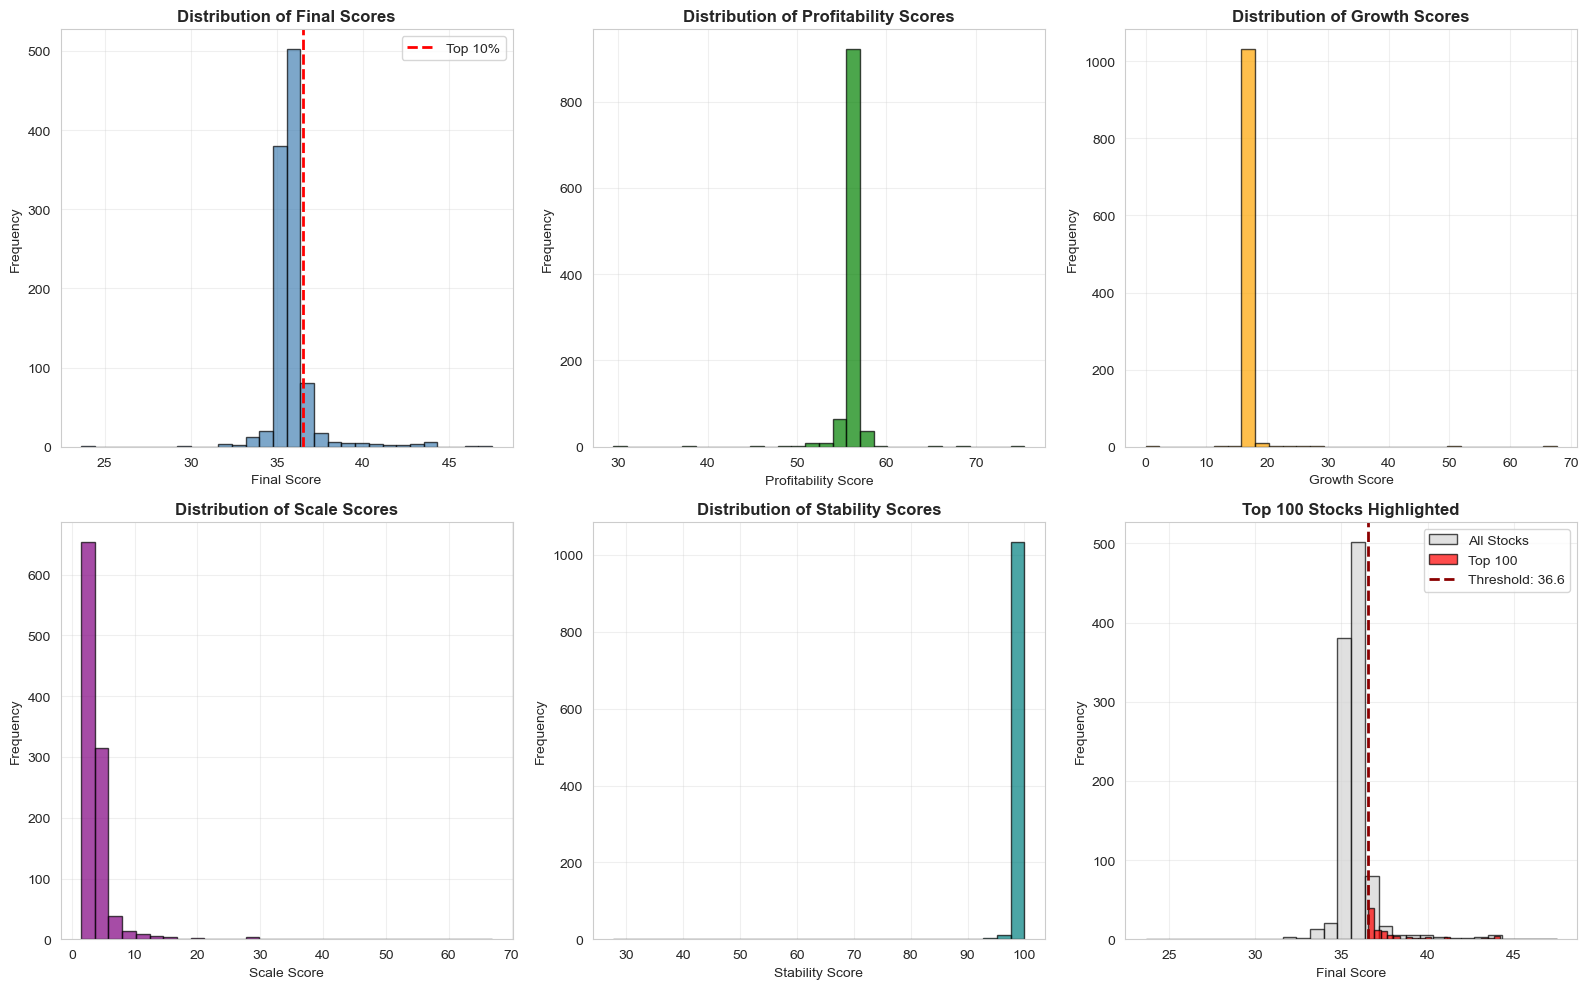


📊 Top 100 threshold score: 36.56


In [20]:
# Visualize score distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Final Score
axes[0, 0].hist(stock_metrics['final_score'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(stock_metrics['final_score'].quantile(0.9), color='red', linestyle='--', linewidth=2, label='Top 10%')
axes[0, 0].set_xlabel('Final Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Final Scores', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Profitability
axes[0, 1].hist(stock_metrics['profitability_score'], bins=30, color='green', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Profitability Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Profitability Scores', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Growth
axes[0, 2].hist(stock_metrics['growth_score'], bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Growth Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Growth Scores', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# Scale
axes[1, 0].hist(stock_metrics['scale_score'], bins=30, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Scale Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Scale Scores', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Stability
axes[1, 1].hist(stock_metrics['stability_score'], bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Stability Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Stability Scores', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# Top 100 highlight
top_100_threshold = stock_metrics.nsmallest(100, 'rank')['final_score'].min()
axes[1, 2].hist(stock_metrics['final_score'], bins=30, color='lightgray', edgecolor='black', alpha=0.7, label='All Stocks')
axes[1, 2].hist(stock_metrics.head(100)['final_score'], bins=30, color='red', edgecolor='black', alpha=0.7, label='Top 100')
axes[1, 2].axvline(top_100_threshold, color='darkred', linestyle='--', linewidth=2, label=f'Threshold: {top_100_threshold:.1f}')
axes[1, 2].set_xlabel('Final Score')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Top 100 Stocks Highlighted', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Top 100 threshold score: {top_100_threshold:.2f}")

### 6. Export Top 100 Stocks

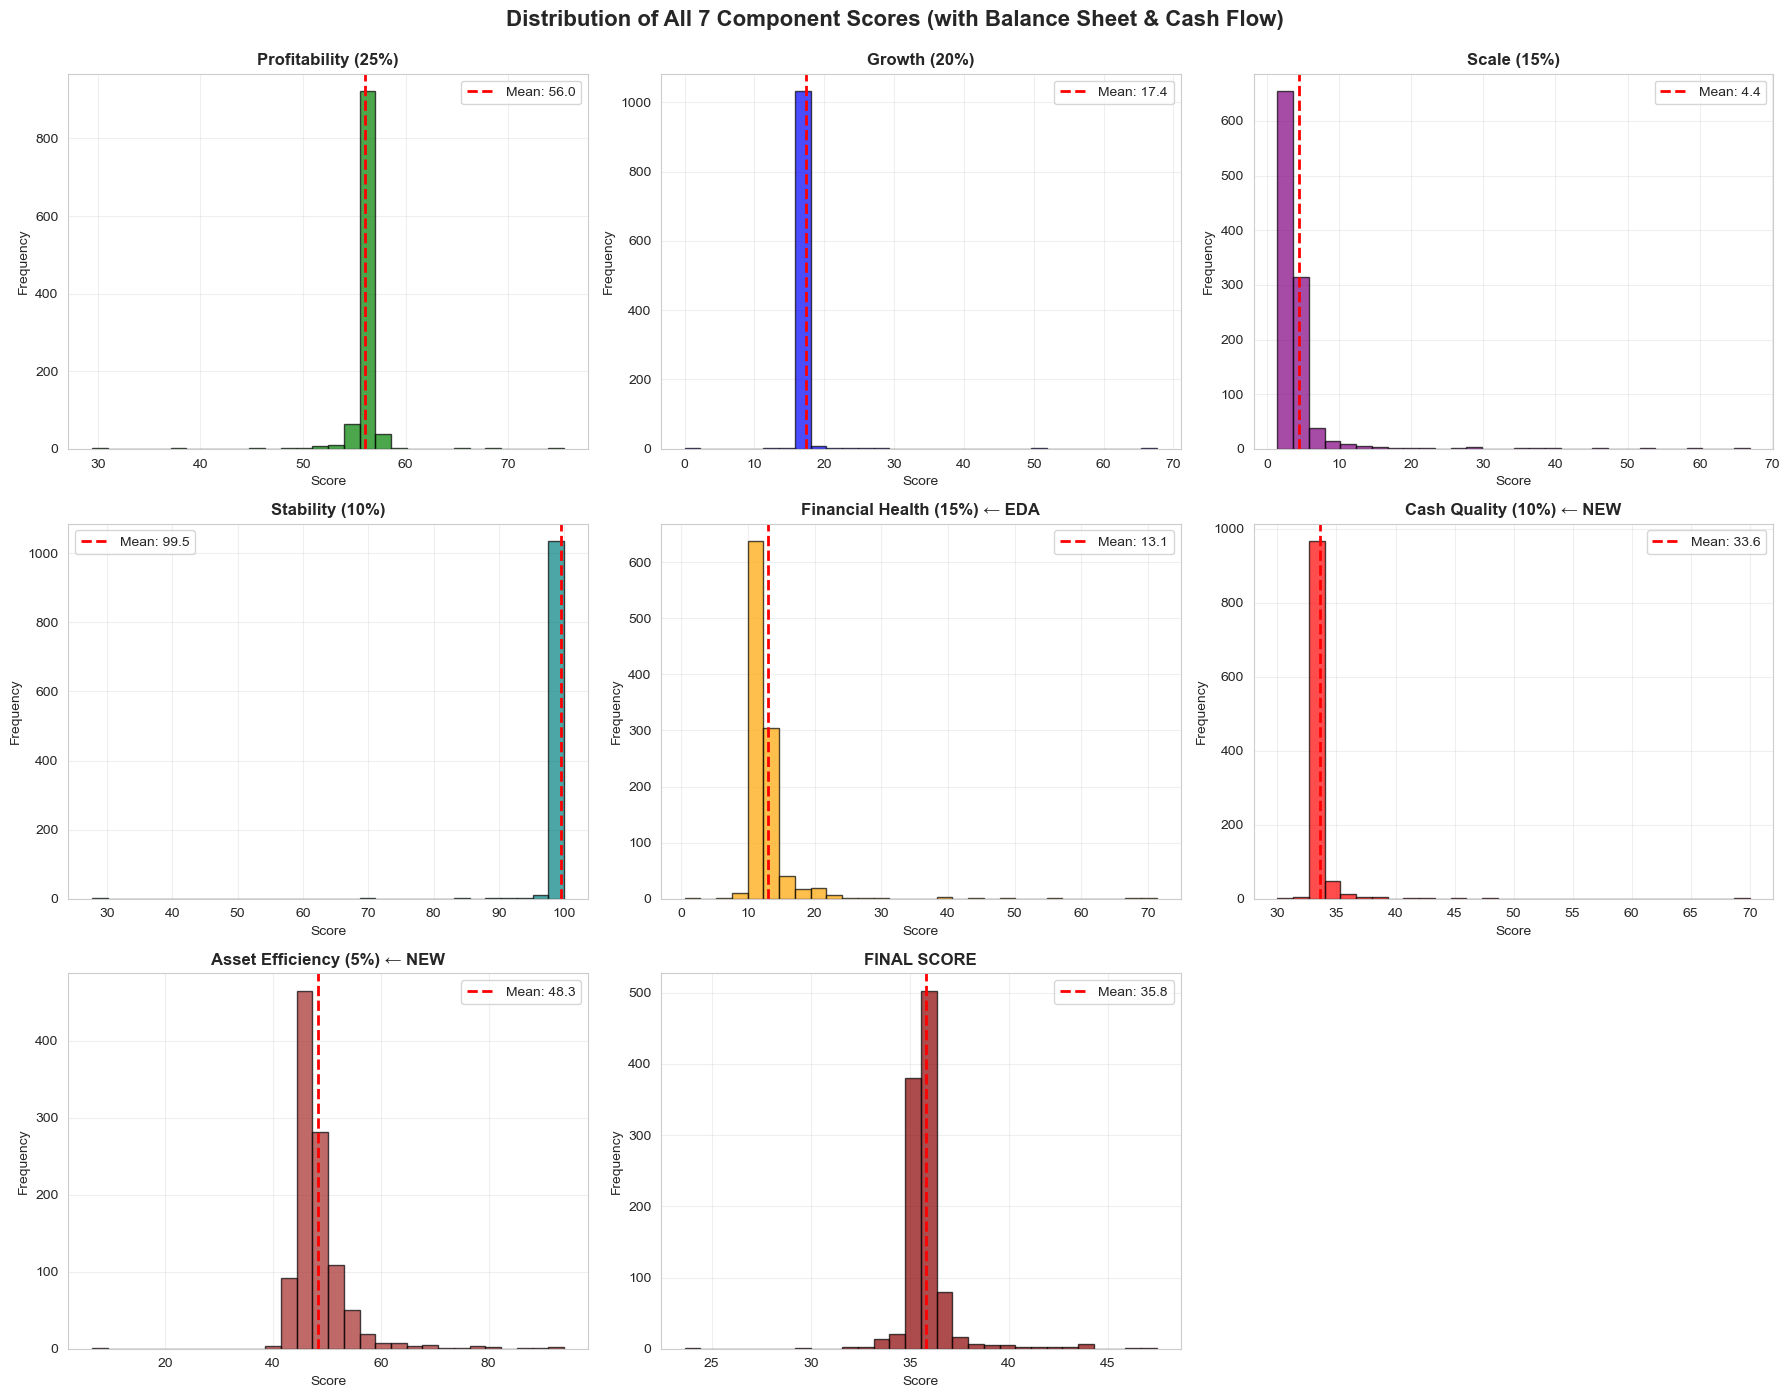


📊 All 7 component scores visualized!
✓ Notice how Financial Health, Cash Quality, and Asset Efficiency add new dimensions to ranking


In [21]:
# Visualize ALL 7 component score distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of All 7 Component Scores (with Balance Sheet & Cash Flow)', 
             fontsize=16, fontweight='bold', y=0.995)

scores_to_plot = [
    ('profitability_score', 'Profitability (25%)', 'green'),
    ('growth_score', 'Growth (20%)', 'blue'),
    ('scale_score', 'Scale (15%)', 'purple'),
    ('stability_score', 'Stability (10%)', 'teal'),
    ('financial_health_score', 'Financial Health (15%) ← EDA', 'orange'),
    ('cash_quality_score', 'Cash Quality (10%) ← NEW', 'red'),
    ('asset_efficiency_score', 'Asset Efficiency (5%) ← NEW', 'brown'),
    ('final_score', 'FINAL SCORE', 'darkred'),
]

for idx, (score_col, title, color) in enumerate(scores_to_plot):
    row = idx // 3
    col = idx % 3
    
    ax = axes[row, col]
    ax.hist(stock_metrics[score_col], bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add mean line
    mean_val = stock_metrics[score_col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.legend()

# Hide the last empty subplot
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 All 7 component scores visualized!")
print("✓ Notice how Financial Health, Cash Quality, and Asset Efficiency add new dimensions to ranking")


In [23]:
# Select top 100 stocks
top_100 = stock_metrics.head(100).copy()

# Prepare export data with ALL 7 component scores
export_data = top_100[['symbol', 'rank', 'final_score', 
                        'profitability_score', 'growth_score', 'scale_score', 'stability_score',
                        'financial_health_score', 'cash_quality_score', 'asset_efficiency_score',  # ← MỚI
                        'avg_revenue', 'avg_net_profit', 'avg_gross_margin', 'avg_net_margin',
                        'avg_revenue_growth', 'avg_profit_growth',
                        'avg_roa', 'avg_roe',  # ← MỚI (from EDA)
                        'avg_current_ratio', 'avg_de_ratio',  # ← MỚI (from EDA)
                        'avg_ocf_quality', 'avg_fcf',  # ← MỚI (Cash Flow)
                        'avg_asset_turnover']].copy()  # ← MỚI

# Round numeric columns
numeric_cols = export_data.select_dtypes(include=[np.number]).columns
export_data[numeric_cols] = export_data[numeric_cols].round(2)

# Export to CSV
OUTPUT_PATH = Path("../data/raw/top_100_stocks.csv")
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
export_data.to_csv(OUTPUT_PATH, index=False)

print("=" * 80)
print("EXPORT COMPLETE (WITH COMPREHENSIVE METRICS)")
print("=" * 80)
print(f"\n✓ Exported top 200 stocks to: {OUTPUT_PATH}")
print(f"\nFile contains:")
print(f"  • {len(export_data)} stocks")
print(f"  • {len(export_data.columns)} columns (including 7 component scores)")

print(f"\n📋 Columns exported:")
print("\nScores:")
for col in ['final_score', 'profitability_score', 'growth_score', 'scale_score', 'stability_score',
            'financial_health_score', 'cash_quality_score', 'asset_efficiency_score']:
    print(f"  ✓ {col}")

print("\nFinancial Metrics:")
print("  FROM INCOME STATEMENT:")
for col in ['avg_revenue', 'avg_net_profit', 'avg_gross_margin', 'avg_net_margin', 
            'avg_revenue_growth', 'avg_profit_growth']:
    print(f"    • {col}")

print("  FROM BALANCE SHEET (EDA):")
for col in ['avg_roa', 'avg_roe', 'avg_current_ratio', 'avg_de_ratio']:
    print(f"    • {col}")

print("  FROM CASH FLOW STATEMENT:")
for col in ['avg_ocf_quality', 'avg_fcf', 'avg_asset_turnover']:
    print(f"    • {col}")

print(f"\n📊 Top 10 stocks:")
display(export_data[['rank', 'symbol', 'final_score', 'profitability_score', 'financial_health_score', 
                     'cash_quality_score', 'avg_roa', 'avg_current_ratio', 'avg_de_ratio']].head(10))

print(f"\n✅ NEXT STEP: Use {OUTPUT_PATH.name} as input for TA scraping!")
print("🎯 Ranking now considers: Profitability + Growth + Scale + Stability + Financial Health + Cash Quality + Asset Efficiency")
print("=" * 80)


EXPORT COMPLETE (WITH COMPREHENSIVE METRICS)

✓ Exported top 200 stocks to: ..\data\raw\top_100_stocks.csv

File contains:
  • 100 stocks
  • 23 columns (including 7 component scores)

📋 Columns exported:

Scores:
  ✓ final_score
  ✓ profitability_score
  ✓ growth_score
  ✓ scale_score
  ✓ stability_score
  ✓ financial_health_score
  ✓ cash_quality_score
  ✓ asset_efficiency_score

Financial Metrics:
  FROM INCOME STATEMENT:
    • avg_revenue
    • avg_net_profit
    • avg_gross_margin
    • avg_net_margin
    • avg_revenue_growth
    • avg_profit_growth
  FROM BALANCE SHEET (EDA):
    • avg_roa
    • avg_roe
    • avg_current_ratio
    • avg_de_ratio
  FROM CASH FLOW STATEMENT:
    • avg_ocf_quality
    • avg_fcf
    • avg_asset_turnover

📊 Top 10 stocks:


,rank,symbol,final_score,profitability_score,financial_health_score,cash_quality_score,avg_roa,avg_current_ratio,avg_de_ratio
0,1,VHM,47.4900,56.3400,11.7600,70.0000,0.0200,1.1500,1.5200
1,2,PLX,45.9500,56.0600,11.7300,36.9200,0.0100,1.1500,1.7600
2,3,POM,44.1700,75.4500,40.1700,32.1800,-0.0200,0.3300,-202.1200
3,4,CSI,44.0200,55.4800,71.3700,33.2900,-0.0100,114.4000,0.0100
4,5,VOC,43.8800,56.7300,24.2900,33.9500,0.0400,24.6400,0.0700
5,6,VEF,43.8600,69.0800,11.1500,41.0700,0.0400,0.9200,5.0000
6,7,WSS,43.6600,55.7200,68.6600,33.3000,0.0000,109.2200,0.0100
7,8,VIC,43.5400,55.8300,11.2800,42.8500,0.0000,0.9000,3.9600
8,9,VUA,43.4300,54.3400,71.1800,33.2500,-0.0300,114.0200,0.0200
9,10,HPG,43.2300,56.1400,11.8700,47.3900,0.0100,1.1800,0.8800



✅ NEXT STEP: Use top_100_stocks.csv as input for TA scraping!
🎯 Ranking now considers: Profitability + Growth + Scale + Stability + Financial Health + Cash Quality + Asset Efficiency
